In [288]:
import numpy as np
import pandas as pd
from os.path import join
from scipy.spatial.transform import Rotation as R 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [289]:
!ls ../dataset/

04_04_2019_21_17_23  12_04_2019_12_18_35
09_04_2019_17_14_24  12_04_2019_12_18_35.tar.gz


In [290]:


class DataAnalysor:
    def __init__(self, dir_name):
        self.dir_name = join("../dataset", dir_name)
    
    def readGroundTruth(self):
        gt_path = join(self.dir_name, "dataset/ground_truth/result.csv")
        self.df_gt_in_base = pd.read_csv(gt_path,header=None,names=["x","y","z"])
        
    def readProcessedData(self):
        hough_path = join(self.dir_name, "dataset/processed/result_method_hough.csv")
        self.df_hough = pd.read_csv(hough_path)
        
        combile_path = join(self.dir_name, "dataset/processed/result_method_combile.csv")
        self.df_combile = pd.read_csv(combile_path)
        
        morphology_path = join(self.dir_name, "dataset/processed/result_method_morphology.csv")
        self.df_morphology = pd.read_csv(morphology_path)
        
        hough_particle_filter_path = join(self.dir_name, "dataset/processed/result_hough_particle_filter.csv")
        self.df_hough_particle_filter = pd.read_csv(hough_particle_filter_path)

    def computeErrorInBase(self, df_processed_result):
        df = df_processed_result.copy()
        df["0_error_x"] = (df_processed_result["corners_in_base_0_x"] - self.df_gt_in_base["x"][0]).abs()
        df["1_error_x"] = (df_processed_result["corners_in_base_1_x"] - self.df_gt_in_base["x"][1]).abs()
        df["2_error_x"] = (df_processed_result["corners_in_base_2_x"] - self.df_gt_in_base["x"][2]).abs()
        df["3_error_x"] = (df_processed_result["corners_in_base_3_x"] - self.df_gt_in_base["x"][3]).abs()
        df["0_error_y"] = (df_processed_result["corners_in_base_0_y"] - self.df_gt_in_base["y"][0]).abs()
        df["1_error_y"] = (df_processed_result["corners_in_base_1_y"] - self.df_gt_in_base["y"][1]).abs()
        df["2_error_y"] = (df_processed_result["corners_in_base_2_y"] - self.df_gt_in_base["y"][2]).abs()
        df["3_error_y"] = (df_processed_result["corners_in_base_3_y"] - self.df_gt_in_base["y"][3]).abs()
        df["0_error_z"] = (df_processed_result["corners_in_base_0_z"] - self.df_gt_in_base["z"][0]).abs()
        df["1_error_z"] = (df_processed_result["corners_in_base_1_z"] - self.df_gt_in_base["z"][1]).abs()
        df["2_error_z"] = (df_processed_result["corners_in_base_2_z"] - self.df_gt_in_base["z"][2]).abs()
        df["3_error_z"] = (df_processed_result["corners_in_base_3_z"] - self.df_gt_in_base["z"][3]).abs()
        
        
        self.gt_xyzabc_in_base = np.zeros([6,1])
        self.gt_xyzabc_in_base[0,0] = df_processed_result["gt_xyz_abc_in_base_x"][0]
        self.gt_xyzabc_in_base[1,0] = df_processed_result["gt_xyz_abc_in_base_y"][0]
        self.gt_xyzabc_in_base[2,0] = df_processed_result["gt_xyz_abc_in_base_z"][0]
        self.gt_xyzabc_in_base[3,0] = df_processed_result["gt_xyz_abc_in_base_a"][0]
        self.gt_xyzabc_in_base[4,0] = df_processed_result["gt_xyz_abc_in_base_b"][0]
        self.gt_xyzabc_in_base[5,0] = df_processed_result["gt_xyz_abc_in_base_c"][0]
        # compute xyz_abc in base
        df["error_angle_x"] = 0.0
        df["error_angle_y"] = 0.0
        df["error_angle_z"] = 0.0

        df["error_x_avg"] = 0.0
        df["error_y_avg"] = 0.0
        df["error_z_avg"] = 0.0
        
        df["left_corners_x_avg"] = (df["left_corners_in_pixel_0_x"] + df["left_corners_in_pixel_1_x"] \
                             +df["left_corners_in_pixel_2_x"] + df["left_corners_in_pixel_3_x"]) / 4.0
        df["left_corners_y_avg"] = (df["left_corners_in_pixel_0_y"] + df["left_corners_in_pixel_1_y"] \
                             +df["left_corners_in_pixel_2_y"] + df["left_corners_in_pixel_3_y"]) / 4.0
        
        for index, row in df_processed_result.iterrows():
            if row["success"] == False:
                continue
            
            #df["error_angle_x"][index] = euler_angle_distance(xyzabc_in_base[3:6,0], self.gt_xyzabc_in_base[3:6,0])
            
            error_angle = euler_angle_distance([row["xyz_abc_in_base_a"], row["xyz_abc_in_base_b"], row["xyz_abc_in_base_c"]], 
                                               [row["gt_xyz_abc_in_base_a"], row["gt_xyz_abc_in_base_b"], row["gt_xyz_abc_in_base_c"]])
            df.loc[index, "error_angle_x"] =error_angle[0]
            df.loc[index, "error_angle_y"] =error_angle[1]
            df.loc[index, "error_angle_z"] =error_angle[2]

            #print("error_angle", error_angle)
            df.loc[index, "error_x_avg"] = abs(row["xyz_abc_in_base_x"] - row["gt_xyz_abc_in_base_x"])
            df.loc[index, "error_y_avg"] = abs(row["xyz_abc_in_base_y"] - row["gt_xyz_abc_in_base_y"])
            df.loc[index, "error_z_avg"] = abs(row["xyz_abc_in_base_z"] - row["gt_xyz_abc_in_base_z"])
        return df
        
        
        
        


In [291]:
def getRotationMatrix(abc):
    r = R.from_euler('xyz',abc, degrees=False)
    return r.as_dcm()
def angle_distance(abc_1, abc_2):
    vec1=[0,0,1]
    vec2=[0,0,1]
    vec1 = np.dot(getRotationMatrix(abc_1), vec1)
    vec2 = np.dot(getRotationMatrix(abc_2), vec2)
    print(vec1, vec2)
    cos_angle = np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    if abs(cos_angle - 1.0) < 1e-5:
        return 0
    angle=np.arccos(cos_angle)
    return angle

In [324]:
def euler_angle_distance_method1(abc_1, abc_2): 
    # see http://www.cs.cmu.edu/~cga/dynopt/readings/Rmetric.pdf 
    def d(angle0, angle1):
        return min(abs(angle0-angle1), 2*np.pi - abs(angle0-angle1))
    distance = np.sqrt(d(abc_1[0], abc_2[0])**2 + d(abc_1[1], abc_2[1])**2 + d(abc_1[2], abc_2[2])**2)
    return distance
    
def euler_angle_distance(abc_1, abc_2): 
    # roll is too close to pi/2, lets add a rotation -pi/2 to them
    r1 = R.from_euler('xyz', abc_1, degrees=False)
    r2 = R.from_euler('xyz', abc_2, degrees=False)
    
    # -pi
    roll_compensate = R.from_euler('x', -np.pi/2.0, degrees=False)
    yaw_compensate = R.from_euler('y', -np.pi/2.0, degrees=False)
    
    r1 = roll_compensate * yaw_compensate * r1
    r2 = roll_compensate * yaw_compensate * r2
     
    #r1 = r2.inv() * r1 
    xyz_error = r1.as_euler('xyz', degrees=False)
    print(r1.as_euler('xyz', degrees=False), r2.as_euler('xyz', degrees=False))
    return xyz_error
gt_abc_in_base = [1.598960, 1.633200, -0.010637]
abc = [2.17049, 1.6243299999999998, -0.582609]
r1 = R.from_euler('xyz', gt_abc_in_base, degrees=False)
print(r1.as_quat())

r2 = R.from_euler('xyz', abc, degrees=False)
print(r2.as_quat())
roll_compensate = R.from_euler('x', -np.pi/2.0, degrees=False)
yaw_compensate = R.from_euler('y', -np.pi/2.0, degrees=False)
    
r1 = roll_compensate*yaw_compensate* r1 
r2 = roll_compensate*yaw_compensate* r2

print(r1.as_euler('zxy', degrees=False))
print(r2.as_euler('zxy', degrees=False))

[ 0.49362295  0.50542884 -0.52509191  0.47450665]
[ 0.68006429  0.14970924 -0.70705557  0.1231752 ]
[-0.06244707  0.03874582 -0.00175746]
[-0.11771691  1.18052417 -0.07946382]


In [300]:
data_analysor = DataAnalysor("12_04_2019_12_18_35")
data_analysor.readGroundTruth()
data_analysor.readProcessedData()
print(data_analysor.df_gt_in_base.columns)
print(data_analysor.df_morphology.columns)


Index(['x', 'y', 'z'], dtype='object')
Index(['id', 'success', 'left_corners_in_pixel_0_x',
       'left_corners_in_pixel_0_y', 'left_corners_in_pixel_1_x',
       'left_corners_in_pixel_1_y', 'left_corners_in_pixel_2_x',
       'left_corners_in_pixel_2_y', 'left_corners_in_pixel_3_x',
       'left_corners_in_pixel_3_y', 'right_corners_in_pixel_0_x',
       'right_corners_in_pixel_0_y', 'right_corners_in_pixel_1_x',
       'right_corners_in_pixel_1_y', 'right_corners_in_pixel_2_x',
       'right_corners_in_pixel_2_y', 'right_corners_in_pixel_3_x',
       'right_corners_in_pixel_3_y', 'corners_in_base_0_x',
       'corners_in_base_0_y', 'corners_in_base_0_z', 'corners_in_base_1_x',
       'corners_in_base_1_y', 'corners_in_base_1_z', 'corners_in_base_2_x',
       'corners_in_base_2_y', 'corners_in_base_2_z', 'corners_in_base_3_x',
       'corners_in_base_3_y', 'corners_in_base_3_z', 'xyz_abc_in_cam_x',
       'xyz_abc_in_cam_y', 'xyz_abc_in_cam_z', 'xyz_abc_in_cam_a',
       'xyz_abc_in

In [312]:
data = data_analysor.df_hough.loc[1,["xyz_abc_in_base_a", "xyz_abc_in_base_b", "xyz_abc_in_base_c", "gt_xyz_abc_in_base_a", "gt_xyz_abc_in_base_b", "gt_xyz_abc_in_base_c"]]
euler_angle = [data["xyz_abc_in_base_a"], data["xyz_abc_in_base_b"], data["xyz_abc_in_base_c"]]
gt_euler_angle = [data["gt_xyz_abc_in_base_a"], data["gt_xyz_abc_in_base_b"], data["gt_xyz_abc_in_base_c"]]
print(euler_angle, gt_euler_angle)
euler_angle_distance(euler_angle, gt_euler_angle)

[2.17049, 1.6243299999999998, -0.582609] [1.59896, 1.6332, -0.0106367]
[1.14284204 0.02944539 0.01655536] [-1.54263265  1.50839265  3.13095595]


array([1.14284204, 0.02944539, 0.01655536])

In [302]:
def visualizeCorners(df):
    """
    visualize corners, in order to make sure the abc are correct
    """
    # Set up the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    corner = np.array([[50,50,0], [-50,50,0],[-50,-50,0],[50,-50,0]])
    color = ["r","g","b","y"]
    print(corner.shape[0])
    for i in range(corner.shape[0]):
        rotated_corner = []
        for index, row in df.iterrows():
            angle_a = row["xyz_abc_in_base_a"]
            angle_b = row["xyz_abc_in_base_b"]
            angle_c = row["xyz_abc_in_base_c"]
            print("angle_c", angle_c)
            r = R.from_euler("xyz", [angle_a, angle_b, angle_c], degrees=False)
            #r = R.from_euler("xyz", [0, 0, 0], degrees=False)
            
            new_corner = np.dot(r.as_dcm(), corner[i,:])
            print(new_corner)
            if(index>10):
                break
            rotated_corner.append(new_corner)
        rotated_corner = np.array(rotated_corner)
        print(rotated_corner)
        scatter=ax.scatter(rotated_corner[:,0], rotated_corner[:,1], rotated_corner[:,2], c=color[i])
    fig.show()
    

<IPython.core.display.Javascript object>


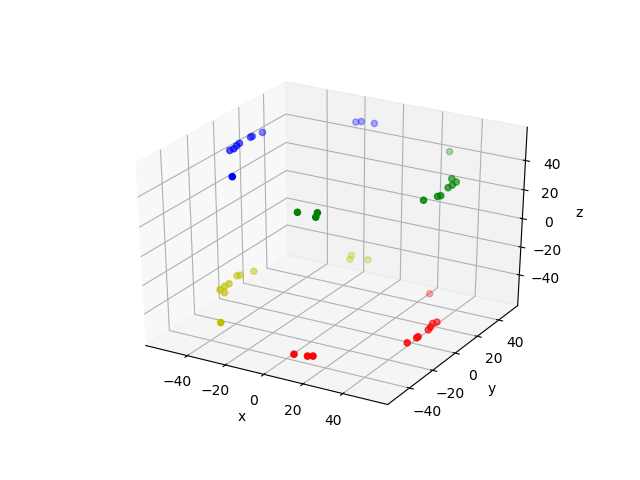

4
angle_c 0.0908927
[ 45.10708268   7.82499787 -53.88989237]
angle_c -0.582609
[ 16.656318   -44.7694816  -52.13694072]
angle_c -0.5926140000000001
[ 13.38511374 -44.02417785 -53.69087906]
angle_c 0.0541541
[ 45.92780129   4.30969706 -53.59163722]
angle_c -0.119992
[ 44.83483808 -12.23313096 -53.29341236]
angle_c 0.138087
[ 43.75662559  12.00256887 -54.23371698]
angle_c 0.46515200000000007
[ 27.1937235   38.07515101 -53.01683013]
angle_c 0.12920299999999998
[ 46.09803431  11.64349453 -52.33928036]
angle_c -0.0214758
[ 45.02817569  -2.97677078 -54.43897712]
angle_c -0.0410001
[ 45.25344455  -4.75893048 -54.12465554]
angle_c -0.663239
[  8.22655624 -46.77779368 -52.3847477 ]
angle_c 0.336138
[ 35.90699609  29.15457549 -53.48549672]
[[ 45.10708268   7.82499787 -53.88989237]
 [ 16.656318   -44.7694816  -52.13694072]
 [ 13.38511374 -44.02417785 -53.69087906]
 [ 45.92780129   4.30969706 -53.59163722]
 [ 44.83483808 -12.23313096 -53.29341236]
 [ 43.75662559  12.00256887 -54.23371698]
 [ 27.19

In [303]:
visualizeCorners(data_analysor.df_hough)

In [297]:

def visualizeErrorHeatMapInBase(success_mask, x, y, z, error, title, filter_fault=False, treshold=100):
    filterd_index = []
    for i in range(len(success_mask)):
        if(success_mask[i] == 1):
            if(not filter_fault):
                filterd_index.append(i)
            elif (filter_fault and error[i] < treshold):
                filterd_index.append(i)
            
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    scatter=ax.scatter(x[filterd_index], y[filterd_index], z[filterd_index], c=error[filterd_index])
    plt.colorbar(scatter, ax=ax)
    fig.show()
def visualizeErrorDistribution(success_mask, error, error_name, filter_fault=False, treshold=100):
    filterd_index = []
    for i in range(len(success_mask)):
        if(success_mask[i] == 1):
            if(not filter_fault):
                filterd_index.append(i)
            elif (filter_fault and error[i] < treshold):
                filterd_index.append(i)
                
    # Set up the plot
    fig = plt.figure()
    
    ax = fig.add_subplot(311)
    
    # Draw the plot
    ax.hist(error[filterd_index], bins = 20,
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
    ax.set_title(error_name + " distribution")
    ax.set_xlabel(error_name)
    ax.set_ylabel("number")
def visualizeSuccessHeatMapInBase(success_mask, x, y, z, error, title, filter_fault=False, treshold=100):
    filterd_index = []
    for i in range(len(success_mask)):
        if(not filter_fault):
            filterd_index.append(i)
        elif (filter_fault and error[i] < treshold):
            filterd_index.append(i)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    scatter=ax.scatter(x[filterd_index], y[filterd_index], z[filterd_index], c=success_mask[filterd_index])
    plt.colorbar(scatter, ax=ax)
    fig.show()
def visualize(df, method):
    %matplotlib notebook
    visualizeErrorHeatMapInBase(df["success"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_x_avg"], method + ": error of x")

    visualizeErrorHeatMapInBase(df["success"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_x_avg"], method + ": error of x", True)

    visualizeSuccessHeatMapInBase(df["success"],df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_x_avg"], method + ": sucess", True)
    print("success ratio: ", np.sum(df["success"])/df["success"].shape[0])

    visualizeErrorDistribution(df["success"], df["error_x_avg"], "Hough: error of x (mm)")
    visualizeErrorDistribution(df["success"], df["error_x_avg"], "Hough: zoomed error of x (mm)", True)

    visualizeErrorHeatMapInBase(df["success"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_y_avg"], method + ": error of y")

    visualizeErrorHeatMapInBase(df["success"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_y_avg"], method + ": error of y", True)

    visualizeErrorDistribution(df["success"], df["error_y_avg"], "Hough: error of y (mm)")
    visualizeErrorDistribution(df["success"], df["error_y_avg"], "Hough: zoomed error of y (mm)", True)
    
    visualizeErrorHeatMapInBase(df["success"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_z_avg"], method + ": error of z")

    visualizeErrorHeatMapInBase(df["success"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_z_avg"], method + ": error of z", True)

    visualizeErrorDistribution(df["success"], df["error_z_avg"], method+": error of z (mm)")
    visualizeErrorDistribution(df["success"], df["error_z_avg"], method+": zoomed error of z (mm)", True)

    visualizeErrorHeatMapInBase(df["success"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_angle_x"]/ np.pi * 180, method + ": error of a(deg)")

    visualizeErrorHeatMapInBase(df["success"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_angle_x"]/ np.pi * 180, method+": error of a(deg)", True)

    visualizeErrorDistribution(df["success"], df["error_angle_x"] / np.pi * 180, method+": error of a (deg)")
    visualizeErrorDistribution(df["success"], df["error_angle_x"] / np.pi * 180, method+": zoomed error of a (deg)", True)

    
    visualizeErrorHeatMapInBase(df["success"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_angle_y"]/ np.pi * 180, method+": error of b(deg)")

    visualizeErrorHeatMapInBase(df["success"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_angle_y"]/ np.pi * 180, method+": error of b(deg)", True)

    visualizeErrorDistribution(df["success"], df["error_angle_y"] / np.pi * 180, method+": error of b (deg)")
    visualizeErrorDistribution(df["success"], df["error_angle_y"] / np.pi * 180, method+": zoomed error of b (deg)", True)

    visualizeErrorHeatMapInBase(df["success"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_angle_z"]/ np.pi * 180, method+": error of c(deg)")

    visualizeErrorHeatMapInBase(df["success"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_angle_z"]/ np.pi * 180, method+": error of c(deg)", True)

    visualizeErrorDistribution(df["success"], df["error_angle_z"] / np.pi * 180, method+": error of c (deg)")
    visualizeErrorDistribution(df["success"], df["error_angle_z"] / np.pi * 180, method+": zoomed error of c (deg)", True)
    

[-0.20339153 -0.00876423 -0.01836305] [-1.54263265  1.50839265  3.13095595]
[1.14284204 0.02944539 0.01655536] [-1.54263265  1.50839265  3.13095595]
[ 1.17138144  0.05247852 -0.01981756] [-1.54263265  1.50839265  3.13095595]
[-0.12912869 -0.005176   -0.01204278] [-1.54263265  1.50839265  3.13095595]
[ 0.21691741  0.00734206 -0.00632879] [-1.54263265  1.50839265  3.13095595]
[-0.2938716  -0.01395757 -0.02563546] [-1.54263265  1.50839265  3.13095595]
[-0.95483015 -0.03194477  0.00120549] [-1.54263265  1.50839265  3.13095595]
[-0.28021646 -0.00631223  0.01478411] [-1.54263265  1.50839265  3.13095595]
[ 0.02283539  0.0001389  -0.03095072] [-1.54263265  1.50839265  3.13095595]
[ 0.06012808  0.00194432 -0.02410463] [-1.54263265  1.50839265  3.13095595]
[1.3126167  0.03947429 0.00998892] [-1.54263265  1.50839265  3.13095595]
[-0.69297616 -0.02626312 -0.00889193] [-1.54263265  1.50839265  3.13095595]
[1.27563013 0.0319311  0.01905095] [-1.54263265  1.50839265  3.13095595]
[-1.99824228 -0.06157

[-1.19120702 -0.04183957  0.00139087] [-1.54263265  1.50839265  3.13095595]
[-0.49988126 -0.01922443 -0.01059238] [-1.54263265  1.50839265  3.13095595]
[-0.17189223 -0.00679346 -0.01123029] [-1.54263265  1.50839265  3.13095595]
[-0.30566659 -0.0114355  -0.00935313] [-1.54263265  1.50839265  3.13095595]
[-1.81578263 -0.0713536   0.00772417] [-1.54263265  1.50839265  3.13095595]
[-0.0326084  -0.00108242 -0.00062079] [-1.54263265  1.50839265  3.13095595]
[1.32024853 0.02674401 0.0282395 ] [-1.54263265  1.50839265  3.13095595]
[ 1.38881745  0.05395815 -0.00501971] [-1.54263265  1.50839265  3.13095595]
[-0.29593251 -0.00671465  0.01463059] [-1.54263265  1.50839265  3.13095595]
[-0.42045462 -0.01474123 -0.00525382] [-1.54263265  1.50839265  3.13095595]
[-0.8070001  -0.03507735 -0.01804554] [-1.54263265  1.50839265  3.13095595]
[-1.4471457  -0.02952203  0.02880375] [-1.54263265  1.50839265  3.13095595]
[-0.27043714 -0.01185619 -0.01970531] [-1.54263265  1.50839265  3.13095595]
[0.40790913 0.0

<IPython.core.display.Javascript object>


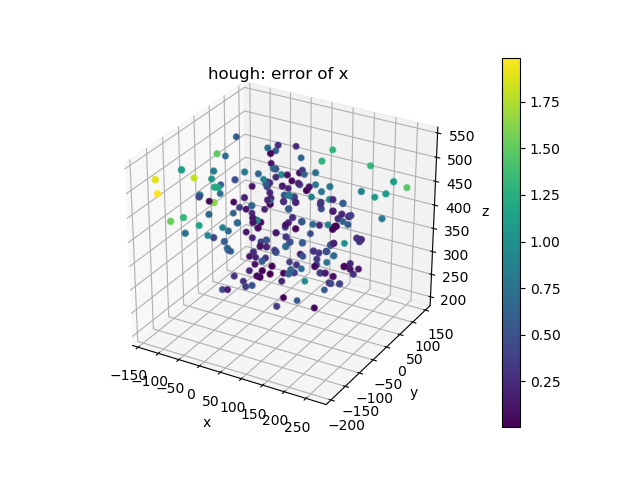

<IPython.core.display.Javascript object>


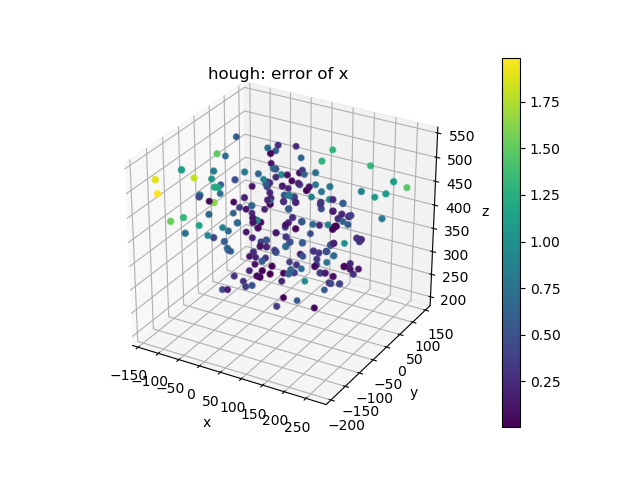

<IPython.core.display.Javascript object>


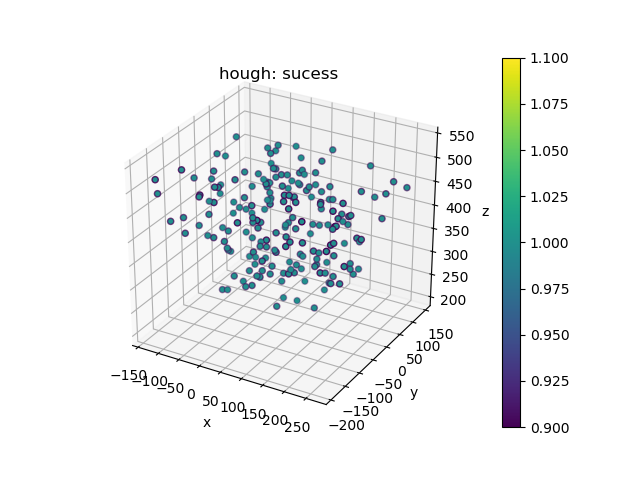

success ratio:  1.0


<IPython.core.display.Javascript object>


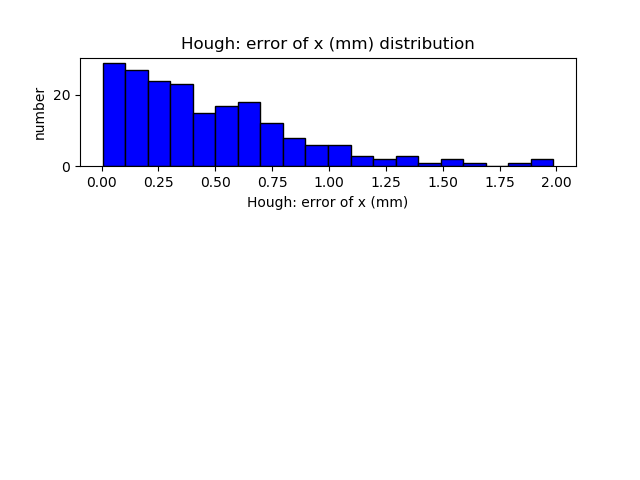

<IPython.core.display.Javascript object>


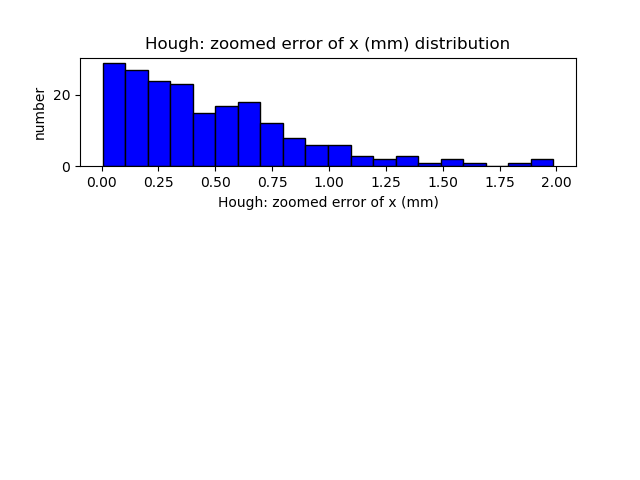

<IPython.core.display.Javascript object>


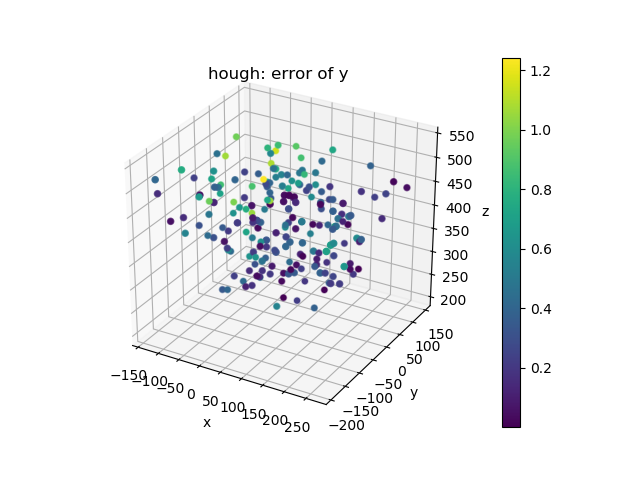

<IPython.core.display.Javascript object>


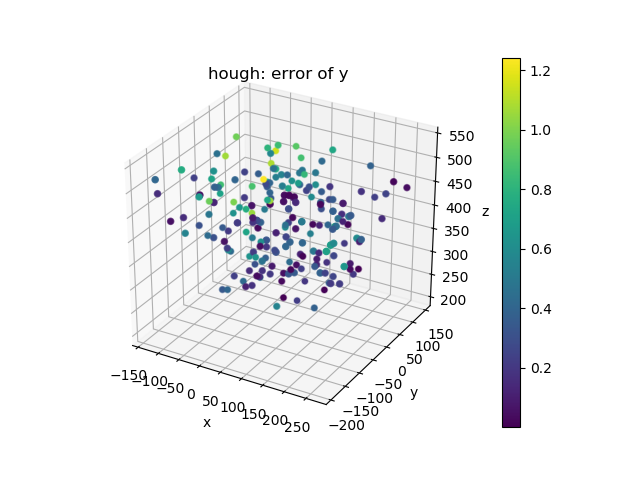

<IPython.core.display.Javascript object>


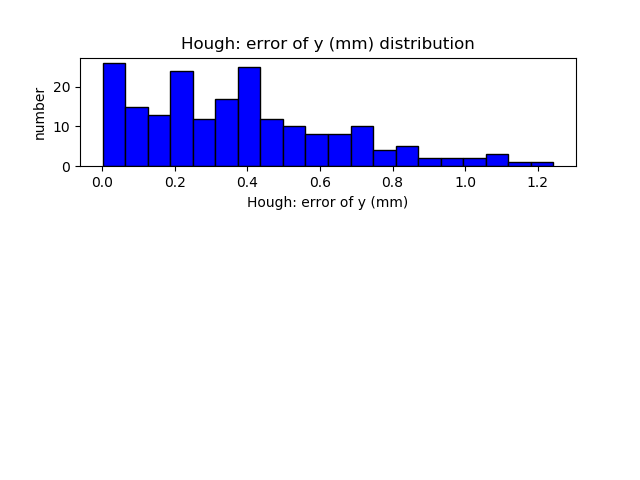

<IPython.core.display.Javascript object>


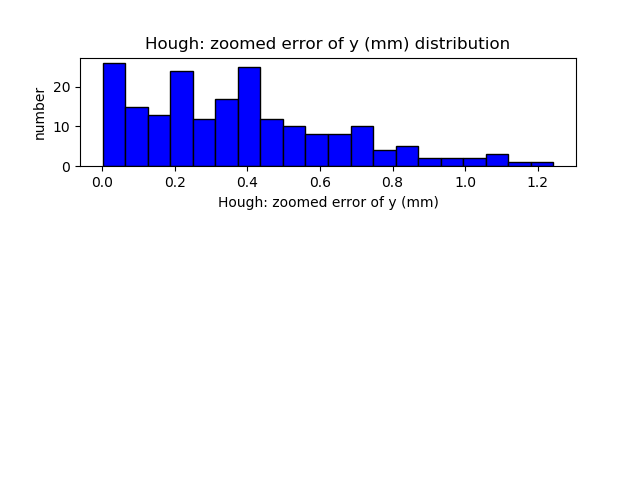

<IPython.core.display.Javascript object>


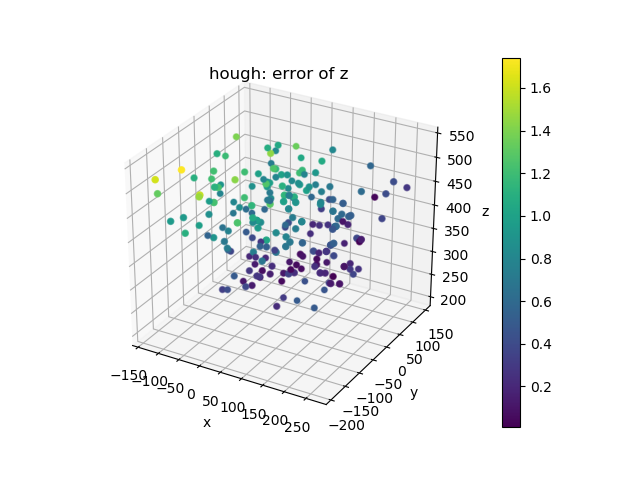

<IPython.core.display.Javascript object>


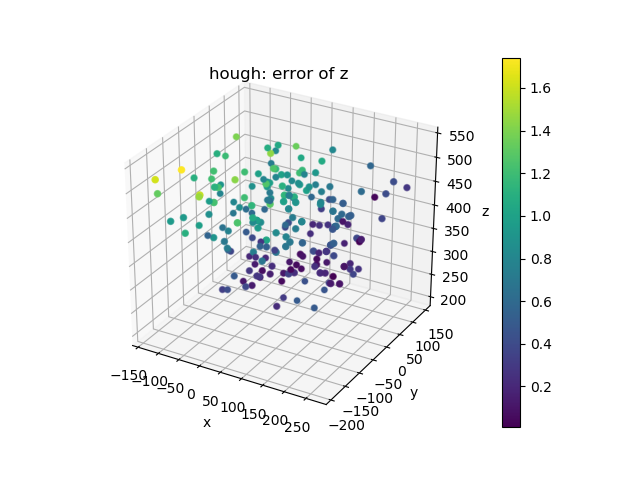

<IPython.core.display.Javascript object>


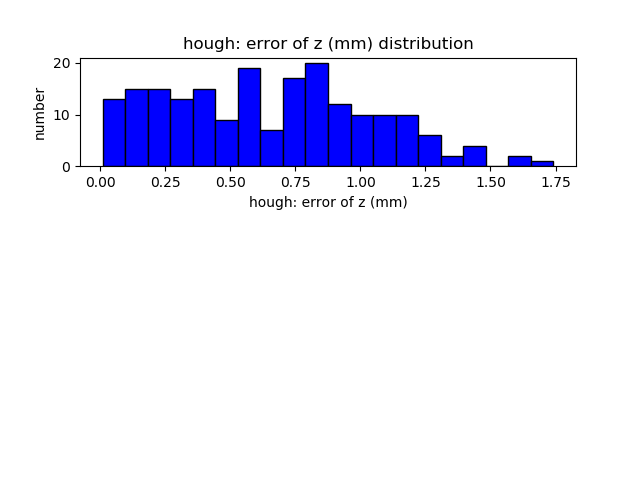

<IPython.core.display.Javascript object>


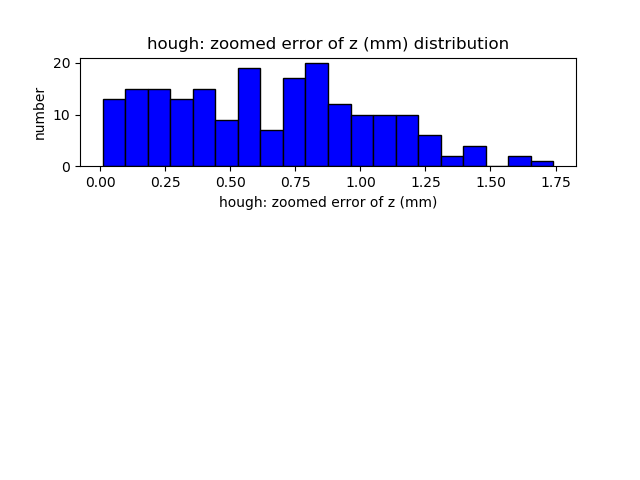

<IPython.core.display.Javascript object>


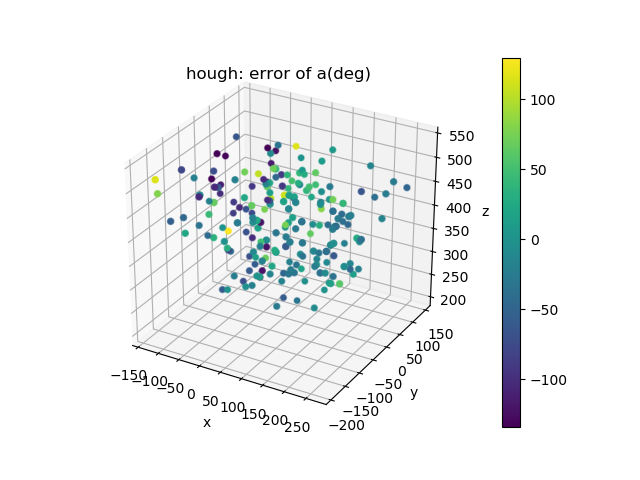

<IPython.core.display.Javascript object>


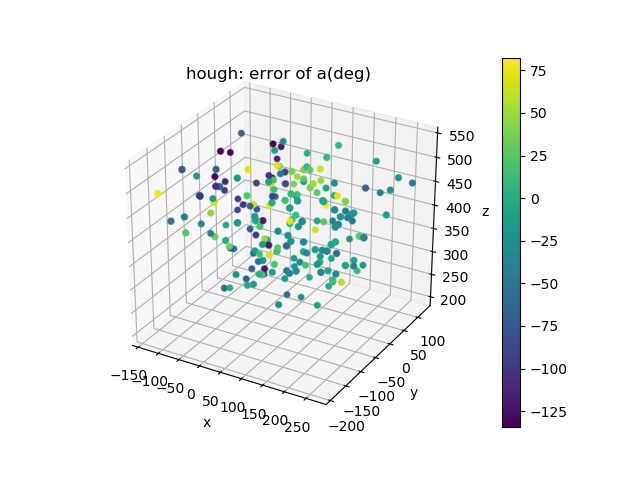

<IPython.core.display.Javascript object>


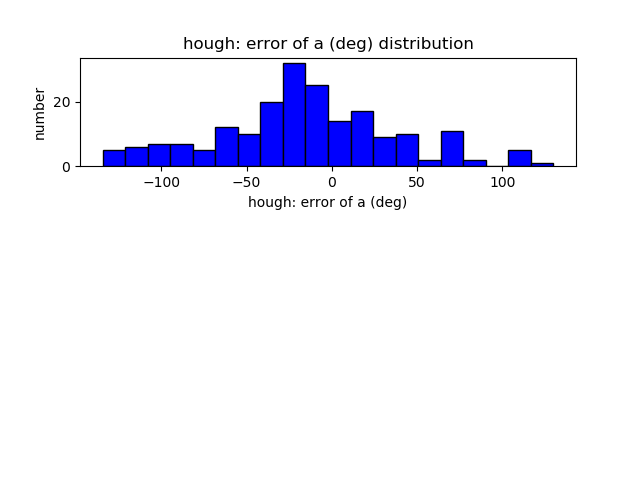

<IPython.core.display.Javascript object>


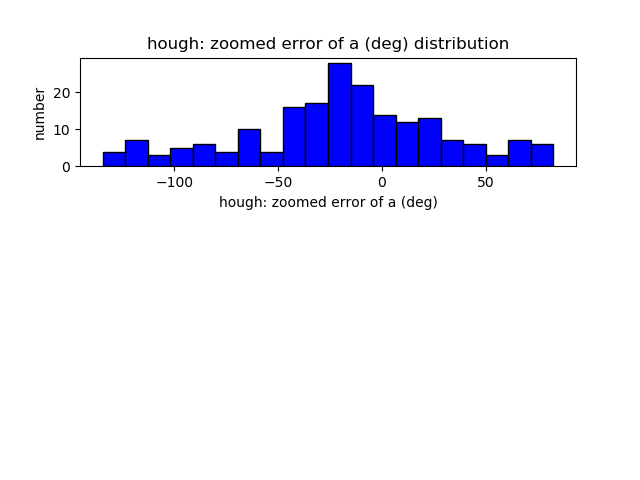

<IPython.core.display.Javascript object>


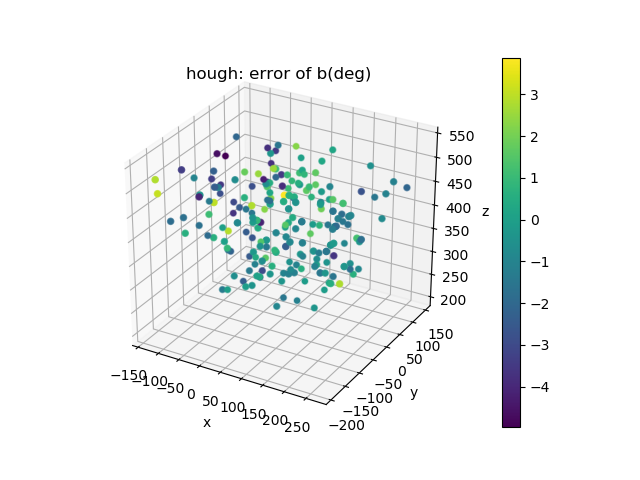

<IPython.core.display.Javascript object>


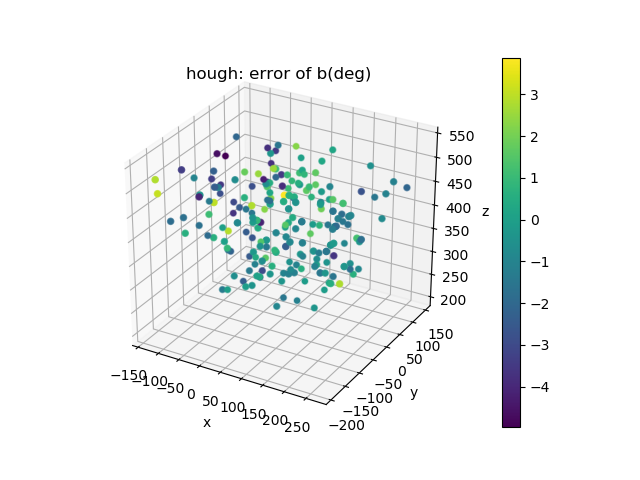

<IPython.core.display.Javascript object>


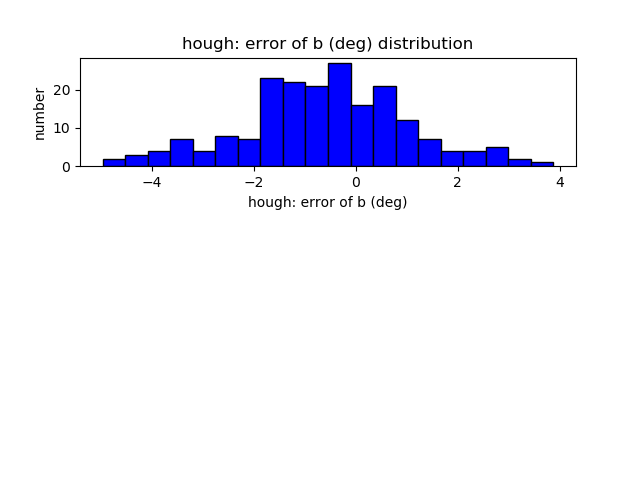

<IPython.core.display.Javascript object>


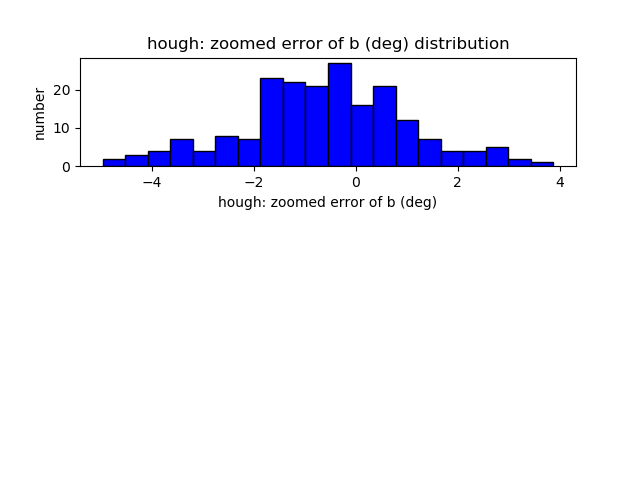

<IPython.core.display.Javascript object>


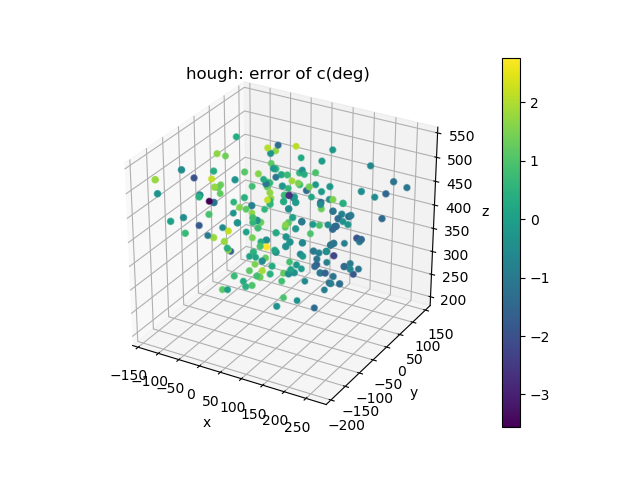

<IPython.core.display.Javascript object>


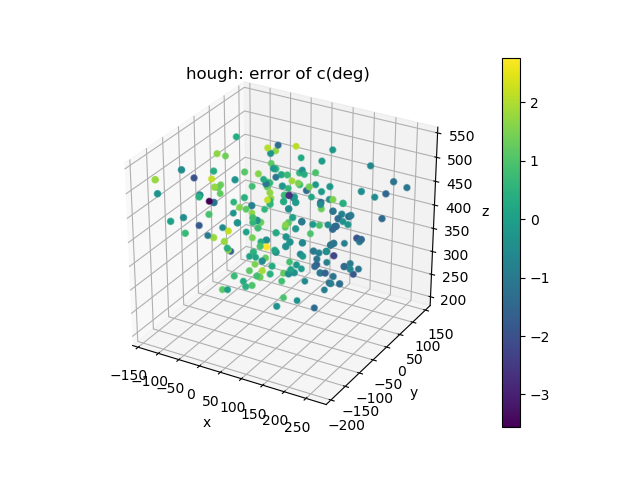

<IPython.core.display.Javascript object>


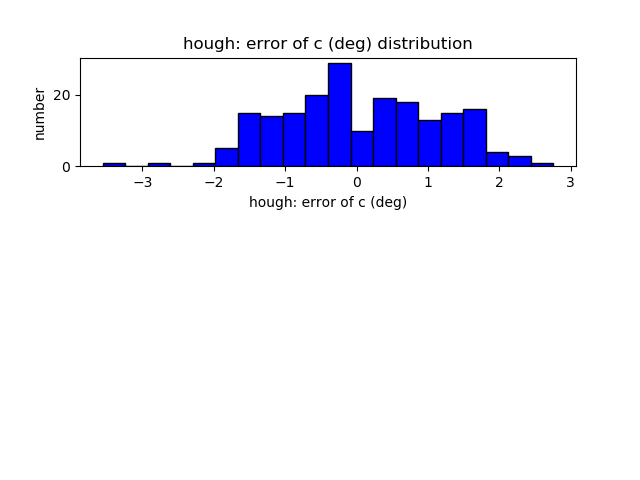

<IPython.core.display.Javascript object>


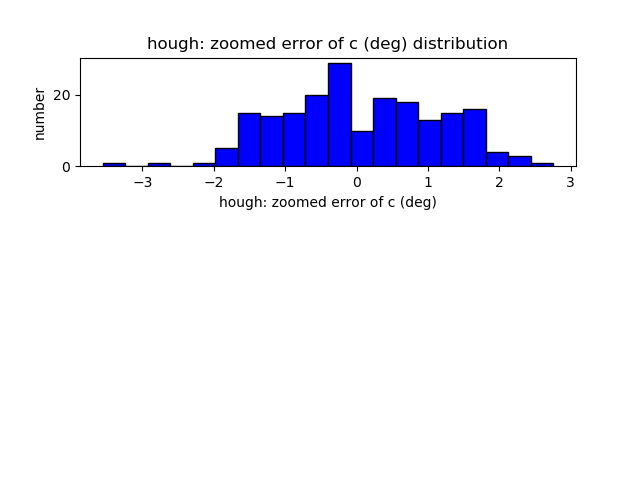

In [304]:
df_hough = data_analysor.computeErrorInBase(data_analysor.df_hough)
visualize(df_hough, "hough")



In [161]:
mask = df_hough["error_x_avg"] > 3.0
df_hough[mask]

Empty DataFrame
Columns: [id, success, left_corners_in_pixel_0_x, left_corners_in_pixel_0_y, left_corners_in_pixel_1_x, left_corners_in_pixel_1_y, left_corners_in_pixel_2_x, left_corners_in_pixel_2_y, left_corners_in_pixel_3_x, left_corners_in_pixel_3_y, right_corners_in_pixel_0_x, right_corners_in_pixel_0_y, right_corners_in_pixel_1_x, right_corners_in_pixel_1_y, right_corners_in_pixel_2_x, right_corners_in_pixel_2_y, right_corners_in_pixel_3_x, right_corners_in_pixel_3_y, corners_in_base_0_x, corners_in_base_0_y, corners_in_base_0_z, corners_in_base_1_x, corners_in_base_1_y, corners_in_base_1_z, corners_in_base_2_x, corners_in_base_2_y, corners_in_base_2_z, corners_in_base_3_x, corners_in_base_3_y, corners_in_base_3_z, xyz_abc_in_cam_x, xyz_abc_in_cam_y, xyz_abc_in_cam_z, xyz_abc_in_cam_a, xyz_abc_in_cam_b, xyz_abc_in_cam_c, xyz_abc_in_tool_x, xyz_abc_in_tool_y, xyz_abc_in_tool_z, xyz_abc_in_tool_a, xyz_abc_in_tool_b, xyz_abc_in_tool_c, xyz_abc_in_base_x, xyz_abc_in_base_y, xyz_abc_in_base_z, xyz_abc_in_base_a, xyz_abc_in_base_b, xyz_abc_in_base_c, gt_xyz_abc_in_base_x, gt_xyz_abc_in_base_y, gt_xyz_abc_in_base_z, gt_xyz_abc_in_base_a, gt_xyz_abc_in_base_b, gt_xyz_abc_in_base_c, gt_xyz_abc_in_cam_x, gt_xyz_abc_in_cam_y, gt_xyz_abc_in_cam_z, gt_xyz_abc_in_cam_a, gt_xyz_abc_in_cam_b, gt_xyz_abc_in_cam_c, 0_error_x, 1_error_x, 2_error_x, 3_error_x, 0_error_y, 1_error_y, 2_error_y, 3_error_y, 0_error_z, 1_error_z, 2_error_z, 3_error_z, error_angle_x, error_angle_y, error_angle_z, error_x_avg, error_y_avg, error_z_avg, left_corners_x_avg, left_corners_y_avg]
Index: []

[0 rows x 80 columns]

error_angle 2.5238052069890418
error_angle 2.1984230967538982
error_angle 2.0698502812911372
error_angle 1.9932602613447146
error_angle 3.8236653095707323
error_angle 3.7476855001181355
error_angle 1.9039778525951925
error_angle 2.095348055039544
error_angle 2.6944815111030174
error_angle 2.3236528736375406
error_angle 2.291664633946084
error_angle 2.1602992577936977
error_angle 2.0476690887321123
error_angle 2.214537909818886
error_angle 2.104617494829167
error_angle 2.0247815726090064
error_angle 3.7507442609700807
error_angle 2.082741810114974
error_angle 3.0425877462094664
error_angle 2.0057280775638557
error_angle 2.1693453382151953
error_angle 2.1211372636491492
error_angle 2.2524979906935347
error_angle 2.1957739894171713
error_angle 2.1509411533094065
error_angle 2.3737467970280655
error_angle 2.0614510908978656
error_angle 2.011159764106273
error_angle 2.1596284177876526
error_angle 2.0570139444809312
error_angle 2.0491321766369786
error_angle 2.1556604586717736
error_angle 2.

<IPython.core.display.Javascript object>


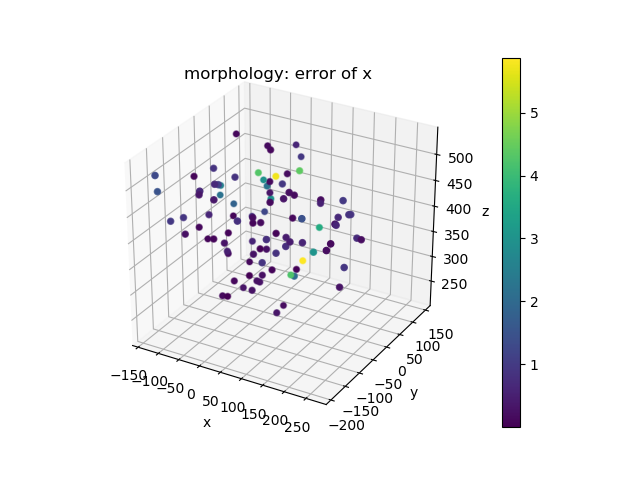

<IPython.core.display.Javascript object>


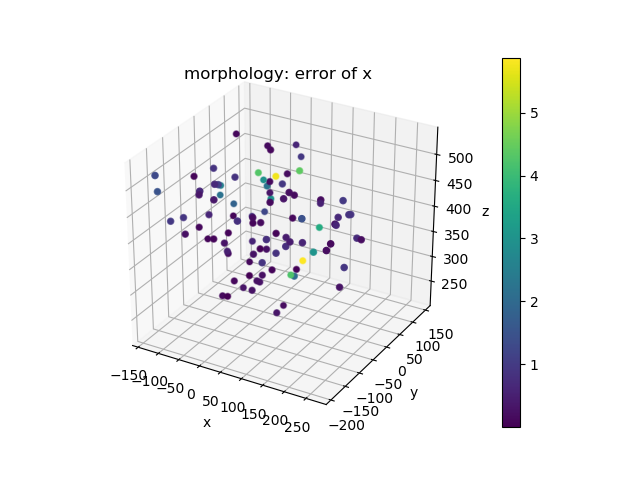

<IPython.core.display.Javascript object>


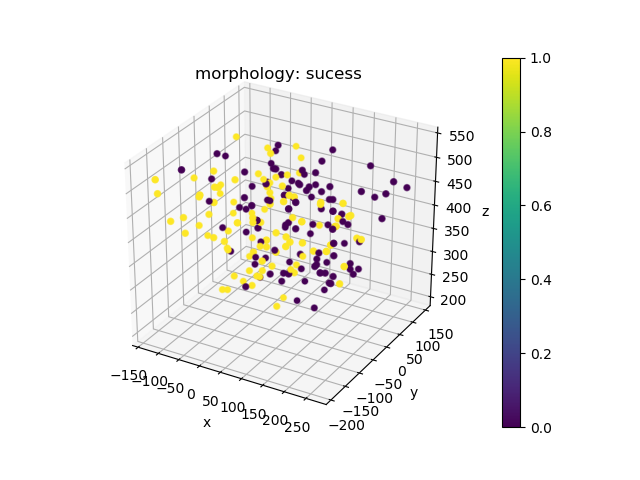

success ratio:  0.485


<IPython.core.display.Javascript object>


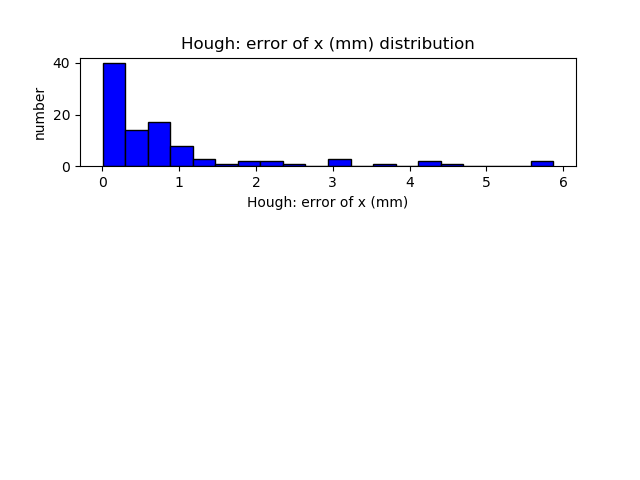

<IPython.core.display.Javascript object>


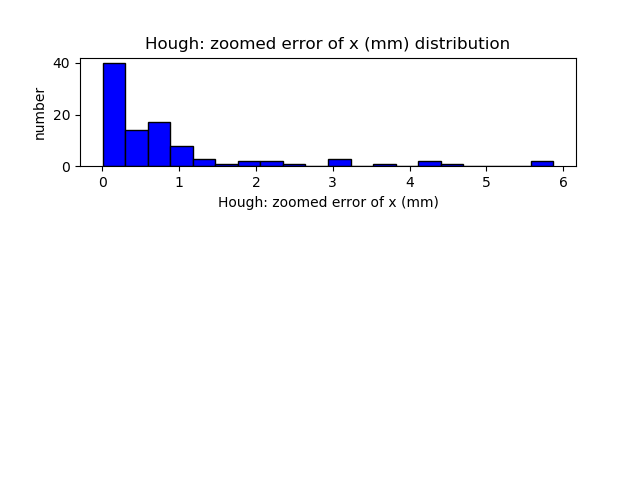

<IPython.core.display.Javascript object>


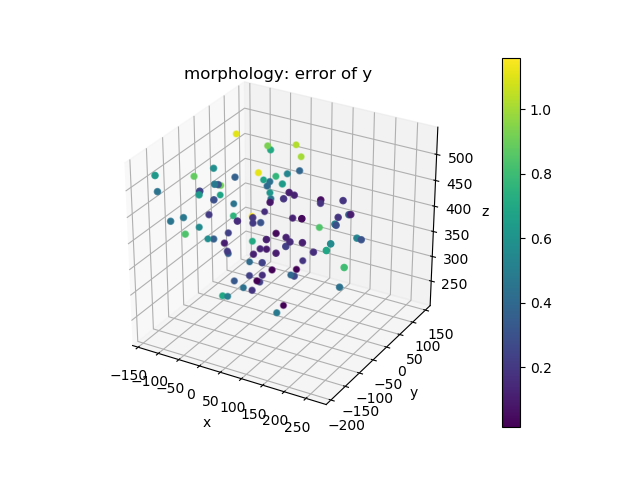

<IPython.core.display.Javascript object>


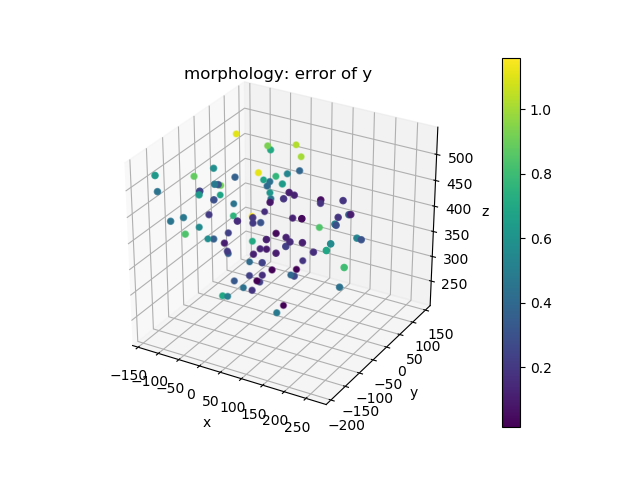

<IPython.core.display.Javascript object>


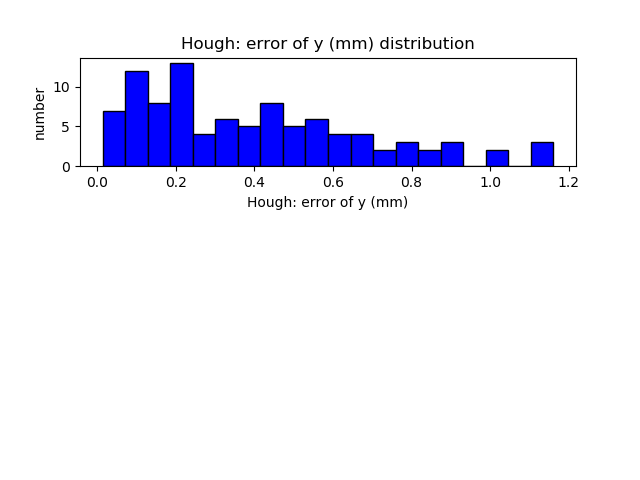

<IPython.core.display.Javascript object>


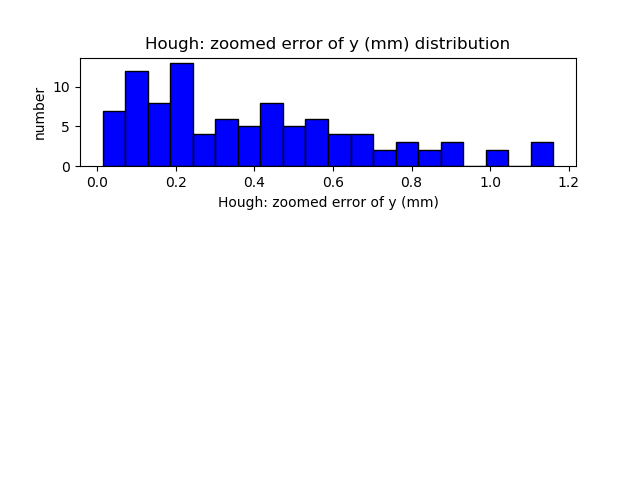

<IPython.core.display.Javascript object>


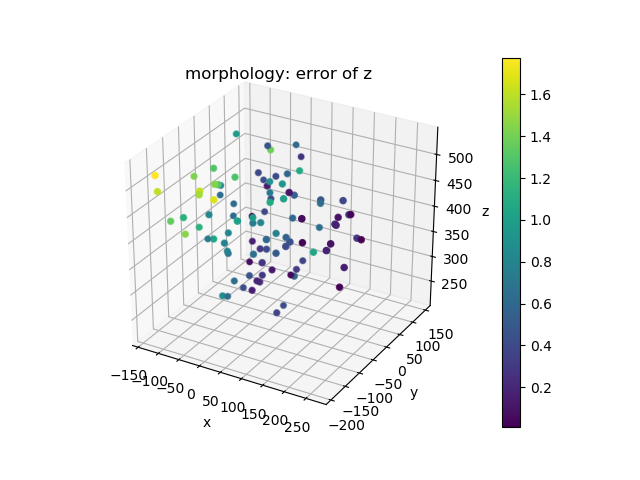

<IPython.core.display.Javascript object>


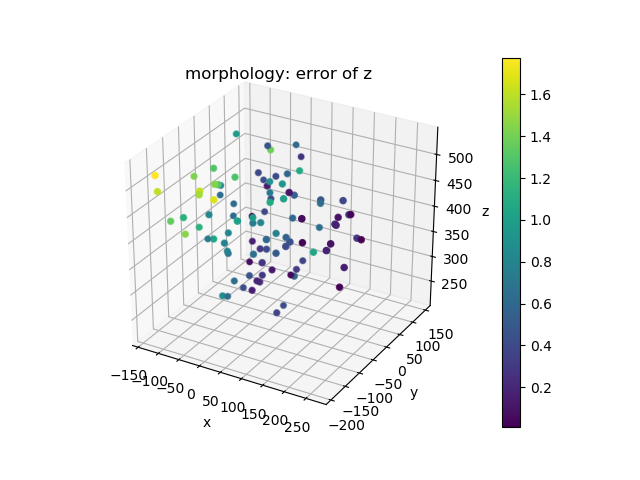

<IPython.core.display.Javascript object>


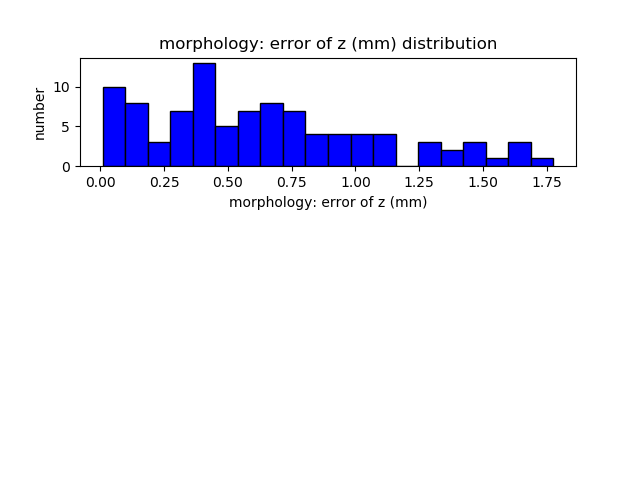

<IPython.core.display.Javascript object>


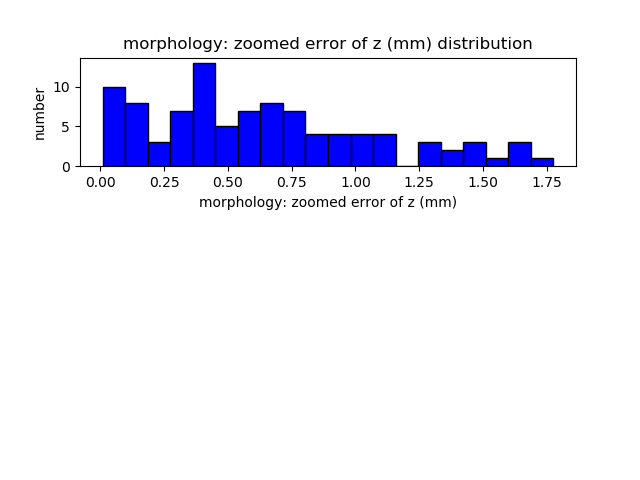

<IPython.core.display.Javascript object>


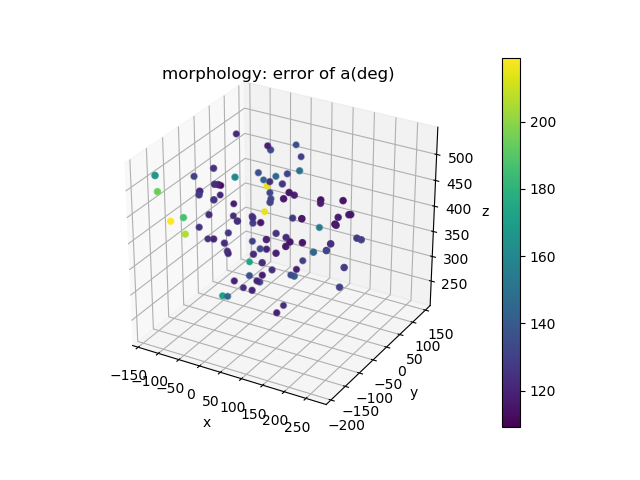

<IPython.core.display.Javascript object>


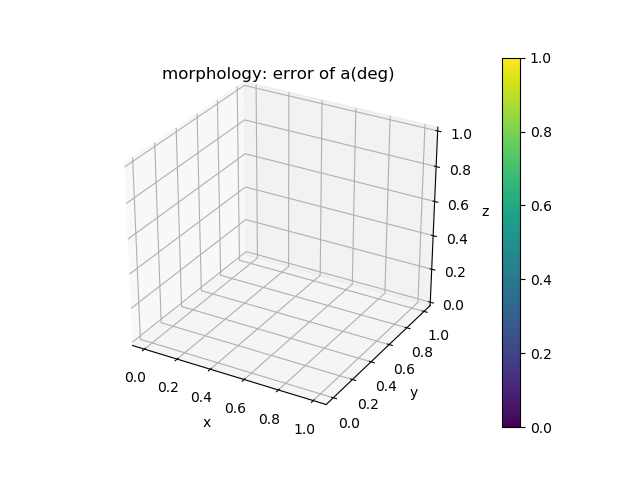

<IPython.core.display.Javascript object>


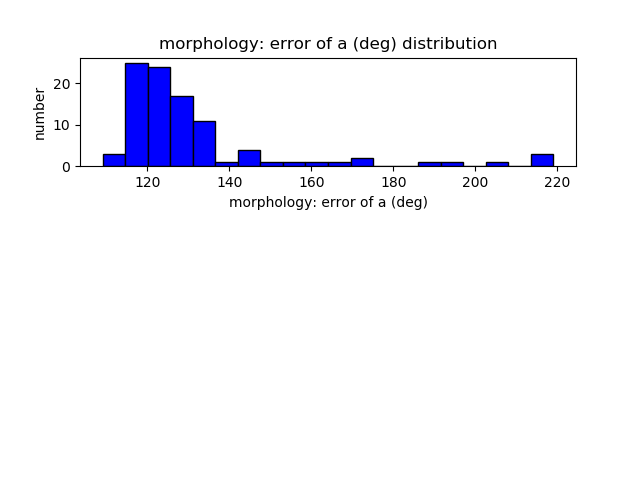

<IPython.core.display.Javascript object>


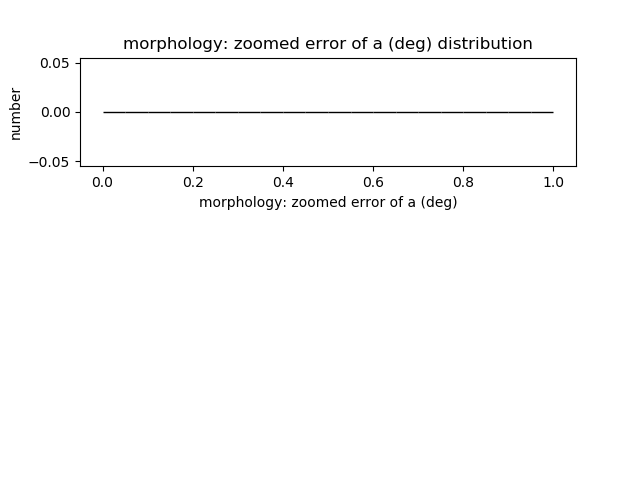

In [35]:

df_morphology = data_analysor.computeErrorInBase(data_analysor.df_morphology)
visualize(df_morphology, "morphology")

In [ ]:

df_combile = data_analysor.computeErrorInBase(data_analysor.df_combile)
visualize(df_combile, "df_combile")


In [ ]:

df_hough_particle_filter = data_analysor.computeErrorInBase(data_analysor.df_hough_particle_filter)
visualize(df_hough_particle_filter, "hough_particle_filter")